In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("microsoft/mpnet-base")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/mpnet-base")


seed = 42

Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original dataset length:  1569
Dataset excluding subsections with length < 21 words: 1542


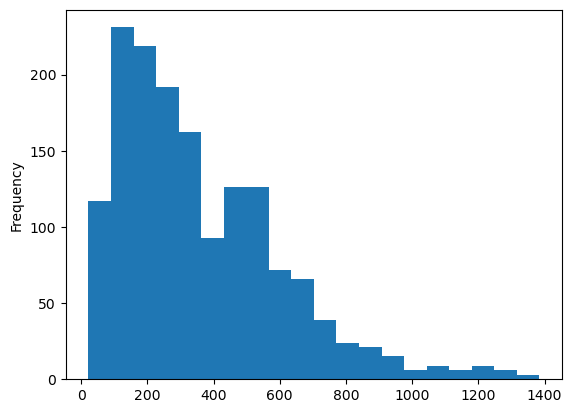

In [2]:
df=pd.read_csv('../data/aqag-chatgpt-vicuna.csv', index_col=0)
df['id'] = df.apply(lambda row: str(row['index']) + '-' + row['type'], axis=1)
print('Original dataset length: ', len(df))

# remove subsections with less than 20 words
df.loc[:,'text_length'] = df['raw_text'].apply(lambda x: len(str(x).split()))
df = df[df['text_length'] > 20]
df['text_length'].plot.hist(bins=20)

print('Dataset excluding subsections with length < 21 words:', len(df))

In [47]:
df1 = df[['index', 'id', 'question', 'correct_answer', 'incorrect_answer', 'correct_answer_vicuna']]
df1.columns = ['index', 'id', 'question', 'gold_answer', 'incorrect_answer', 'correct_answer']
df2 = pd.melt(df1, 
             id_vars=['index','id', 'question', 'gold_answer'],
             value_vars=['incorrect_answer', 'correct_answer'],
             var_name='labels',
             value_name='answer')
df2['text'] = df2['answer'] + tokenizer.sep_token + df2['gold_answer']
df2['labels'] = df2['labels'].apply(lambda x: 0 if x=='incorrect_answer' else 1)

In [48]:
df1 = df[['index', 'id', 'question', 'correct_answer', 'incorrect_answer', 'correct_answer_vicuna']]
df1.columns = ['index', 'id', 'question', 'gold_answer', 'incorrect_answer', 'correct_answer']
df2 = pd.melt(df1, 
             id_vars=['index','id', 'question', 'gold_answer'],
             value_vars=['incorrect_answer', 'correct_answer'],
             var_name='labels',
             value_name='answer')
df2['text'] = df2['answer'] + tokenizer.sep_token + df2['gold_answer']
df2['labels'] = df2['labels'].apply(lambda x: 0 if x=='incorrect_answer' else 1)

In [53]:
from sklearn.model_selection import train_test_split
subsection_index = df['index'].drop_duplicates()
train_index, validtest_index = train_test_split(subsection_index, test_size=0.3,train_size=0.7)
valid_index, test_index = train_test_split(validtest_index, test_size=0.5, train_size=0.5)

train_df = df2[df2['index'].isin(train_index)].dropna()
valid_df = df2[df2['index'].isin(valid_index)].dropna()
test_df = df2[df2['index'].isin(test_index)].dropna()


In [54]:
ds = DatasetDict()
ds['train'] = Dataset.from_pandas(train_df[['id', 'text', 'labels']], preserve_index=False)
ds['valid'] = Dataset.from_pandas(valid_df[['id', 'text', 'labels']], preserve_index=False)
ds['test'] = Dataset.from_pandas(test_df[['id', 'text', 'labels']], preserve_index=False)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 2031
    })
    valid: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 436
    })
    test: Dataset({
        features: ['id', 'text', 'labels'],
        num_rows: 444
    })
})

In [51]:
# def buildDataset(df):
#     full_dataset = Dataset.from_pandas(df, preserve_index=False)
#     # 70% train, 30% test
#     train_valid = full_dataset.train_test_split(test_size=0.3, seed=seed)
#     valid_test = train_valid['test'].train_test_split(test_size=0.5, seed=seed)
    
#     final_dataset = DatasetDict({
#         'train': train_valid['train'],
#         'valid': valid_test['train'],
#         'test': valid_test['test']})
#     print(final_dataset)
#     return final_dataset

In [55]:
ds.save_to_disk("../bin/aqag.hf")


Saving the dataset (0/1 shards):   0%|          | 0/2031 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/444 [00:00<?, ? examples/s]

# Hyperparameter Tuning

In [3]:
import os
from tqdm import tqdm
import numpy as np
from pathlib import Path
import argparse
import logging
import torch
from torch.utils.data import DataLoader
import wandb
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (Trainer, TrainingArguments, DataCollatorWithPadding,
                          AutoTokenizer, AutoModelForSequenceClassification)

In [4]:
model_name_or_path = "microsoft/mpnet-base"
dataset_path = '../bin/multirc_dataset.hf'
output_dir = 'results/hp-tuning'
model_max_length = 512
eval_steps = 1000
eval_accumulation_steps = 2
save_total_limit = 4
batch_size = 32
sweep_id = None
dry_run = False
metric = 'accuracy'
entity = 'ai-aloe'
project_name = 'short answer scoring'

id2label = {0: "incorrect_answer", 1: "correct_answer"}
label2id = {"incorrect_answer": 0, "correct_answer": 1}

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    max_length=model_max_length,
    )

In [5]:
def preprocess_function(example):
    return tokenizer(example["text"])
    
def load_dataset(dataset_path):
    ds = DatasetDict.load_from_disk(dataset_path)
    ds = ds.map(preprocess_function, batched=False)
    return ds

In [6]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [7]:
def train():
    ''' The main training loop.
    '''
    wandb.init()
    
    config = wandb.config

    model = AutoModelForSequenceClassification.from_pretrained(
            model_name_or_path,
            num_labels=2,
            id2label=id2label,
            label2id=label2id
        )
        
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy='steps',
        save_strategy='steps',
        logging_strategy='steps',
        eval_steps=eval_steps,
        save_steps=eval_steps,
        eval_accumulation_steps=eval_accumulation_steps,
        save_total_limit=save_total_limit,
        optim='adamw_torch',
        learning_rate=config.learning_rate,
        num_train_epochs=config.epochs,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        load_best_model_at_end=False,
        disable_tqdm=False,
        report_to='wandb',
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_dict['train'],
        eval_dataset=dataset_dict['valid'],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    trainer.train()

In [164]:
dataset_dict = load_dataset(dataset_path)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16, return_tensors='pt')

if not sweep_id:
    sweep_goal = 'maximize'
        
    if dry_run:
        sweep_name = 'dry-run'
    else:
        sweep_name = f'{model_name_or_path}'
            
    sweep_config = {
        'name': sweep_name,
        'method': 'bayes',
        'metric': {
            'name': f'eval/{metric}',
            'goal': sweep_goal,
        },
        'parameters':
        {
            'epochs': {
                'values': [2, 3, 4, 5]
            },
            'learning_rate': {
                'distribution': 'uniform',
                'min': 1e-5,
                'max': 2e-5,
            },
            'weight_decay': {
                'values': [0.3]
            },
        },
    }

    sweep_id = wandb.sweep(sweep_config,
                            entity=entity,
                            project=project_name)

else:
    sweep_id = sweep_id
        
wandb.agent(sweep_id, train, count=20)

Loading cached processed dataset at /home/jovyan/active-projects/textbook-question-generation/bin/aqag.hf/train/cache-5b977ada71e85085.arrow
Loading cached processed dataset at /home/jovyan/active-projects/textbook-question-generation/bin/aqag.hf/valid/cache-1aac21e4ae60c552.arrow
Loading cached processed dataset at /home/jovyan/active-projects/textbook-question-generation/bin/aqag.hf/test/cache-cbfad58d25290f44.arrow
wandb: ERROR Error while calling W&B API: An internal error occurred. Please contact support. (<Response [500]>)
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: i7zmhhch
Sweep URL: https://wandb.ai/ai-aloe/short%20answer%20scoring/sweeps/i7zmhhch


wandb: ERROR Error while calling W&B API: run ai-aloe/automatic question and answer scoring/epwnsa5f was previously created and deleted; try a new run name (<Response [409]>)
Thread SenderThread:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/apis/normalize.py", line 41, in wrapper
    return func(*args, **kwargs)
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/internal_api.py", line 1690, in upsert_run
    response = self.gql(
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/internal_api.py", line 257, in gql
    ret = self._retry_gql(
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/lib/retry.py", line 131, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/internal_api.py", line 285, in execute
    return self.cl

Thread WriterThread:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 49, in run
    self._run()
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 100, in _run
    self._process(record)
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/internal.py", line 380, in _process
    self._wm.write(record)
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/writer.py", line 154, in write
    write_handler(record)
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/writer.py", line 164, in write_request
    return write_request_handler(record)
  File "/home/jovyan/conda_envs/WesleyEnv/lib/python3.10/site-packages/wandb/sdk/internal/writer.py", line 182, in write_request_status_report
    self._write(record)
  File "/home

Problem at: /tmp/ipykernel_223/3945396169.py 4 train


wandb: ERROR Run 9f9dqdm2 errored: MailboxError('transport failed')


Problem at: /tmp/ipykernel_223/3945396169.py 4 train


wandb: While tearing down the service manager. The following error has occurred: [Errno 32] Broken pipe
wandb: Agent Starting Run: ir9k703t with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 1.924368062741957e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,192
train/total_flos,402494136936960.0
train/train_loss,0.38235


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 81epzaip with config:
wandb: 	epochs: 4
wandb: 	learning_rate: 1.3394816837986323e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,4.0
train/global_step,256
train/total_flos,537453663895680.0
train/train_loss,0.37366


wandb: Agent Starting Run: mccazo16 with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 1.7222883453449535e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,192
train/total_flos,402494136936960.0
train/train_loss,0.41544


wandb: Agent Starting Run: 8wmpi7m7 with config:
wandb: 	epochs: 4
wandb: 	learning_rate: 1.4039359535747886e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,4.0
train/global_step,256
train/total_flos,537453663895680.0
train/train_loss,0.36417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qmudgta7 with config:
wandb: 	epochs: 2
wandb: 	learning_rate: 1.9726158930262455e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,2.0
train/global_step,128
train/total_flos,267896387679360.0
train/train_loss,0.47261


wandb: Agent Starting Run: t5im43l2 with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 1.0958242772017908e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,192
train/total_flos,402494136936960.0
train/train_loss,0.45794


wandb: Agent Starting Run: ejpd6eol with config:
wandb: 	epochs: 2
wandb: 	learning_rate: 1.710155866948203e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,2.0
train/global_step,128
train/total_flos,267896387679360.0
train/train_loss,0.47988


wandb: Agent Starting Run: 1v2ep2k6 with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 1.3478840296179905e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,192
train/total_flos,402494136936960.0
train/train_loss,0.42133


wandb: Agent Starting Run: 3zhqsqor with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 1.901231089481695e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,192
train/total_flos,402494136936960.0
train/train_loss,0.38293


wandb: Agent Starting Run: 2po1qo5f with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 1.1564144587423063e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,5.0
train/global_step,320
train/total_flos,671969190948480.0
train/train_loss,0.34668


wandb: Agent Starting Run: uj2lfw4j with config:
wandb: 	epochs: 2
wandb: 	learning_rate: 1.9444370604052582e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,2.0
train/global_step,128
train/total_flos,267896387679360.0
train/train_loss,0.47676


wandb: Agent Starting Run: 36ngwzdb with config:
wandb: 	epochs: 4
wandb: 	learning_rate: 1.0275363350065345e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,4.0
train/global_step,256
train/total_flos,537453663895680.0
train/train_loss,0.40944


wandb: Agent Starting Run: xi5ably8 with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 1.9867049311627343e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,5.0
train/global_step,320
train/total_flos,671969190948480.0
train/train_loss,0.28198


wandb: Agent Starting Run: 2xhx5dfv with config:
wandb: 	epochs: 2
wandb: 	learning_rate: 1.6178178686140594e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,2.0
train/global_step,128
train/total_flos,267896387679360.0
train/train_loss,0.49914


wandb: Agent Starting Run: o9uczkgc with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 1.189896516709904e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,192
train/total_flos,402494136936960.0
train/train_loss,0.44604


wandb: Agent Starting Run: zd9zw3yp with config:
wandb: 	epochs: 4
wandb: 	learning_rate: 1.3548128788871774e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,4.0
train/global_step,256
train/total_flos,537453663895680.0
train/train_loss,0.3674


wandb: Agent Starting Run: 49mripvn with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 1.040782907037013e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,192
train/total_flos,402494136936960.0
train/train_loss,0.48835


wandb: Agent Starting Run: urnwpode with config:
wandb: 	epochs: 4
wandb: 	learning_rate: 1.6422027904832395e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,4.0
train/global_step,256
train/total_flos,537453663895680.0
train/train_loss,0.34411


wandb: Agent Starting Run: pxuuit3o with config:
wandb: 	epochs: 5
wandb: 	learning_rate: 1.6108607293181748e-05
wandb: 	weight_decay: 0.3


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifie

Step,Training Loss,Validation Loss


train/epoch,▁
train/global_step,▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,5.0
train/global_step,320
train/total_flos,671969190948480.0
train/train_loss,0.32072
